### Author: 陳韋勳

因為專案前半部沒有模組化，沒有資料可以提供給這份檔案。以下程式碼為架構形式，要待有實際資料才可以執行。

此份程式碼目標是希望藉由Attention機制產生能判斷牛熊市的因子，搭配原始作者預測的y，再透過一個NN model來使模型多考慮牛熊市狀況。

Abstract
* Load in data and preprocess data
* Attention mechanism
* If performance is not well, try tuning parameters by optimizing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

## Load in data and preprocess data

In [2]:
dataFolderPath = 'C:/Users/jason/Desktop/Data/programming/python/deep_learning/g_research/2ndModel/2022_01_24_to_2022_05_24/'

In [3]:
trainData = pd.read_csv(dataFolderPath +'train_before_2022_01_24_data.csv')
print(trainData.shape)
trainData.head()

(699105, 15)


,Unnamed: 0.1,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,date,Unnamed: 0,Weight,Asset_Name
0,0,1514764860,1,229.0,13835.1940,14013.80,13666.11,13850.1760,31.550062,13827.062093,-0.014643,2018-01-01 00:01:00,NaN,6.779922,Bitcoin
1,1,1514764860,6,173.0,738.3025,746.00,732.51,738.5075,335.987856,738.839291,-0.004809,2018-01-01 00:01:00,NaN,5.894403,Ethereum
2,2,1514764920,1,235.0,13835.0360,14052.30,13680.00,13828.1020,31.046432,13840.362591,-0.015037,2018-01-01 00:02:00,NaN,6.779922,Bitcoin
3,3,1514764920,6,192.0,738.5075,745.14,732.49,738.2600,232.793141,738.268967,-0.004441,2018-01-01 00:02:00,NaN,5.894403,Ethereum
4,4,1514764980,1,528.0,13823.9000,14000.40,13601.00,13801.3140,55.061820,13806.068014,-0.010309,2018-01-01 00:03:00,NaN,6.779922,Bitcoin


In [4]:
trainData.columns

Index(['Unnamed: 0.1', 'timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low',
       'Close', 'Volume', 'VWAP', 'Target', 'date', 'Unnamed: 0', 'Weight',
       'Asset_Name'],
      dtype='object')

In [5]:
# Drop useless columns: ['Unnamed: 0.1', 'Unnamed: 0', 'date, 'Weight]
trainData = trainData.drop(['Unnamed: 0.1', 'Unnamed: 0', 'date', 'Weight', 'Asset_Name'], axis=1)
print(trainData.shape)
trainData.head()

(699105, 10)


,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,1,229.0,13835.1940,14013.80,13666.11,13850.1760,31.550062,13827.062093,-0.014643
1,1514764860,6,173.0,738.3025,746.00,732.51,738.5075,335.987856,738.839291,-0.004809
2,1514764920,1,235.0,13835.0360,14052.30,13680.00,13828.1020,31.046432,13840.362591,-0.015037
3,1514764920,6,192.0,738.5075,745.14,732.49,738.2600,232.793141,738.268967,-0.004441
4,1514764980,1,528.0,13823.9000,14000.40,13601.00,13801.3140,55.061820,13806.068014,-0.010309


In [6]:
# Get start day and end day
date = pd.to_datetime(trainData[trainData['Asset_ID'] == 1]['timestamp'], unit='s').sort_values()
print('Start day of the data: ', date.iloc[0])
print('End day of the data: ', date.iloc[-1])

# Mark! Data only contains these.

Start day of the data:  2018-01-01 00:01:00
End day of the data:  2018-08-31 18:00:00


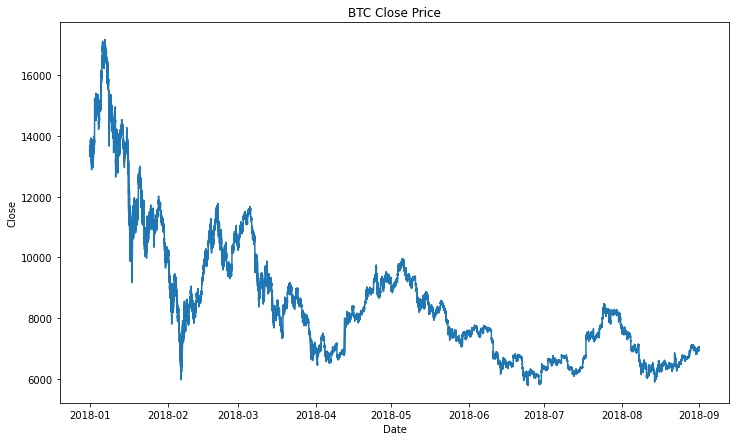

In [7]:
# Check btc close price plot
btcClose = trainData[trainData['Asset_ID'] == 1]['Close']
fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.set_title('BTC Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close')
ax1.plot(date, btcClose);

## Attention mechanism
設計直覺：<br>原始訓練資料中有包含18年的熊市，但我們觀察到原作者模型在熊市時的表現不佳，認為可能是過去熊市的資料比較少，大部分是牛市的資料，因此希望可以設計出一個判斷牛熊市的因子。<br>所以我們使用Attention機制取得訓練資料集的加權Target，搭配原作者訓練好的模型所產生的y predict，將這兩個features當作新的因子(甚至可以放入跟牛熊市有相關的因子)，放入一個nn model中去預測Target，希望能透過這種Attention機制讓模型多考慮牛熊市狀況。

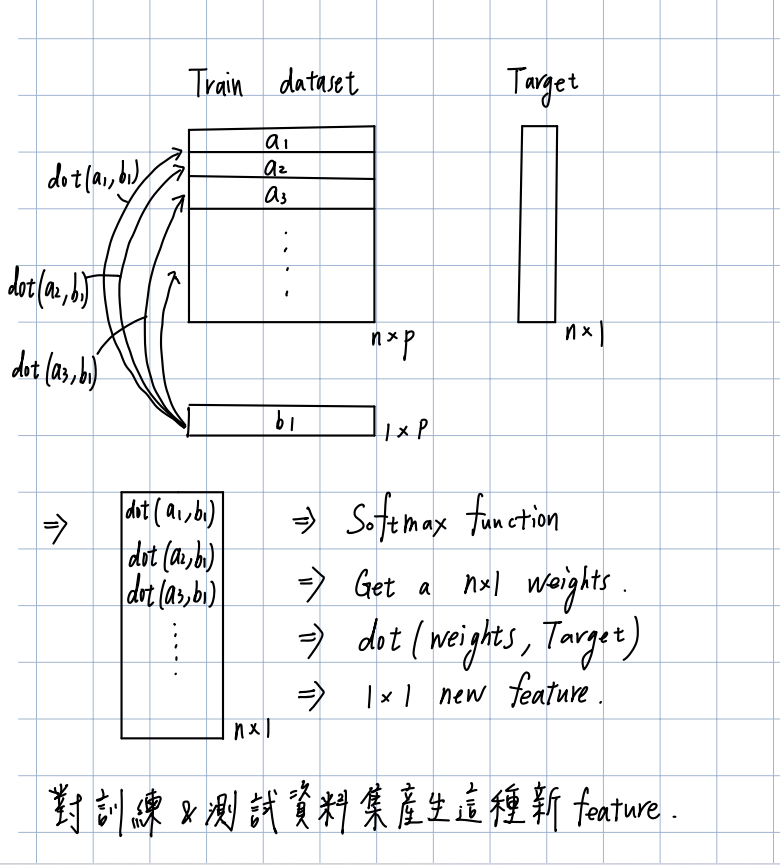

In [ ]:
# Transform train data into numpy to accelerate
train = trainData.values
print(train.shape)
target = np.nan_to_num(trainData['Target'].values)
print(target.shape)

In [9]:
# Functions used to calculate attention

def weightsTransformation(x:np.ndarray):
    return x / sum(x)

# Mark! Accelerate!
# If the latter model's performance is not well, we can let model learn the weight rather than using dot product 
def calAttention(train:np.ndarray, target:np.ndarray):
    '''
    Calculate score by using dot product between two arrays.
    '''
    attentionList = []
    size = target.shape[0]
    for i in range(size):
        curArray = train[i]
        temp = curArray * train
        weight = np.sum(temp, axis=1)
        weight = np.nan_to_num(weight)

        # Get weights
        weight = weightsTransformation(weight)
        # Get attention
        attention = np.dot(weight, target)
        attentionList.append(attention)
        
    return attentionList

In [10]:
# Get train data's 
attentionList = calAttention(train, target)
print(attentionList)

In [ ]:
# Merge attentionList & original model's y prediction to form a new train dataset (shape=(n, 2))
xTrain = np.stack(trainData['yPredict'].values, attentionList).T
print(xTrain.shape)

## NN model using pytorch with given parameters
Because I don't have data to train, I just create the structure

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
class customeDataset(Dataset):
    def __init__(self, xData, yData):
        self.xData = xData.copy()
        self.yData = yData.copy()
        self.xData = torch.from_numpy(self.xData).to(torch.float32)
        self.yData = torch.from_numpy(self.yData).to(torch.float32)

    def __len__(self):
        return len(self.yData)
    
    def __getitem__(self, idx):
        return self.xData[idx], self.yData[idx]

In [ ]:
train_dataset = customeDataset(xTrain, yTrain)
valid_dataset = customeDataset(xVal, yVal)

train_dataloader = DataLoader(train_dataset, batch_size=64)
valid_dataloader = DataLoader(valid_dataset, batch_size=64)

In [ ]:
# layers & neurons need to be tuned

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )
    
    def forward(self, x):
        out = self.net(x)
        return out


def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred.flatten(), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def predict(model, xVal, yVal):
    pred = model(torch.from_numpy(xVal).to(torch.float32)).flatten()
    print(torch.mean(torch.square(pred - torch.from_numpy(yVal))))

In [ ]:
learning_rate = 0.001037366238068126
batch_size = 64
epochs = 1000

model = NeuralNetwork()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) #, weight_decay=1e-5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    #test_loop(valid_dataloader, model, loss_fn)
print("Done!")

In [ ]:
pred = model(torch.from_numpy(xVal).to(torch.float32)).flatten()
print(torch.mean(torch.square(pred - torch.from_numpy(yVal))))

## If performance is not well, try tuning parameters by optimizing
The following code will find a set of parameters, e.g. num of layers, num of neurons, lr rate that can optimize the model performance
(By using keras)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras import regularizers
import optuna

In [ ]:
def base_model(layers, neuronInEachLayers):
        num_input = keras.Input(shape=(8,), name='num_data')
        out = num_input

        for i in range(layers):
            # Add one or more hidden layers
            out = keras.layers.Dense(
                neuronInEachLayers[i], 
                activation='relu',
                kernel_regularizer=regularizers.L2(l2=1e-4))(out)
            out = keras.layers.Dropout(0.2, input_shape=(neuronInEachLayers[i],))(out)

        out = keras.layers.Dense(1, activation='linear', name='prediction')(out)

        model = keras.Model(
            inputs=num_input,
            outputs=out
            )
        return model

def objective(
    trial,
    x_train=xTrain,
    x_val=xVal,
    y_train=yTrain,
    y_val=yVal):

    layers = 10
    neuronInEachLayers = []
    for i in range(layers):
        neuronInEachLayers.append(trial.suggest_int("neuronsInLayer{number}".format(number = i), 20, 300))
    learningRate = trial.suggest_float("learning_rate", 0.001, 1.0)
    batch = 64
    
    model = base_model(layers, neuronInEachLayers)
    
    model.compile(
        keras.optimizers.Adam(learning_rate=learningRate),
        loss=tf.keras.losses.MeanSquaredError()
        )
    
    train_history = model.fit(
        x=xTrain, y=yTrain,
        batch_size=batch, epochs=500,
        validation_data=(xVal, yVal))
    
    return np.mean(np.square(yVal - model.predict(xVal).flatten()))


# Creating Optuna object and defining its parameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

# Showing optimization results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)